## Sentiment Classifier (Positive News / Other News)

Instead of Positive, Negative, and Neutral News, we will only classify news as 'positive' (1) or otherwise (0), since we are only concerned with positive articles and our dataset is comprised of positive and unclassified news (removed suspected positive articles through pre-defined sentiment analysis tool `textblob`).

Reference: https://chrisalbon.com/machine_learning/preprocessing_text/tf-idf/

In [172]:
import pandas as pd
import matplotlib.pyplot as plt
from textblob import TextBlob
from nltk.corpus import stopwords
import pickle 

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from random import *

___

### Cleaning 'Other' (Negative/Neutral) Articles

In [99]:
df_other = pd.read_json('data/unclassifiedarticles.json')

In [100]:
def calculate_polarity(row):
    return TextBlob(row).sentiment.polarity
    
df_other['polarity'] = df_other['transcript'].apply(calculate_polarity)

In [101]:
df_other['polarity'].describe()

count    1013.000000
mean        0.076154
std         0.073877
min        -0.347619
25%         0.037120
50%         0.076446
75%         0.117075
max         0.408225
Name: polarity, dtype: float64

#### Removing suspected positive articles

In [102]:
df_other = df_other[df_other['polarity'] <= 0.117] # Remove everything above 75% percentile

In [103]:
len(df_other)

759

#### Assumption: All articles in the current 'df_other' are either negative or neutral, and none are clearly positive.

---

### Cleaning Positive Articles

In [104]:
df_positive = pd.read_json('data/total_data_2.json')

In [105]:
df_positive.head(2)

,Unnamed: 0,title,url,date,transcript,source
0,0,16-Year-Old Has Been Using His Flying Lessons ...,https://www.goodnewsnetwork.org/teen-flies-sup...,2020-04-09,16-year-old TJ Kim may not have his driver’s l...,goodnewsnetwork.org
1,1,Tyler Perry Picks Up the Tab for All Groceries...,https://www.goodnewsnetwork.org/tyler-perry-pa...,2020-04-09,It’s not uncommon for movie mogul Tyler Perry ...,goodnewsnetwork.org


In [106]:
try:
    df_positive = df_positive.drop('Unnamed: 0', axis = 1)
except:
    pass

In [107]:
def calculate_polarity(row):
    return TextBlob(row).sentiment.polarity
    
df_positive['polarity'] = df_positive['transcript'].apply(calculate_polarity)

In [108]:
df_positive['polarity'].describe()

count    1062.000000
mean        0.135837
std         0.178191
min        -0.133333
25%         0.041512
50%         0.108415
75%         0.171805
max         1.000000
Name: polarity, dtype: float64

In [109]:
df_positive = df_positive[df_positive['polarity'] >= 0.04] # Remove everything below 25% percentile

In [110]:
len(df_positive)

798

____

### Data Joining, Pre-Processing and Feature Engineering

In [147]:
df_positive['positivity'] = 1
df_other['positivity'] = 0

In [148]:
df = pd.concat([df_positive, df_other])

In [149]:
df.head(2)

,title,url,date,transcript,source,polarity,positivity
0,16-Year-Old Has Been Using His Flying Lessons ...,https://www.goodnewsnetwork.org/teen-flies-sup...,2020-04-09,16-year-old TJ Kim may not have his driver’s l...,goodnewsnetwork.org,0.214592,1
1,Tyler Perry Picks Up the Tab for All Groceries...,https://www.goodnewsnetwork.org/tyler-perry-pa...,2020-04-09,It’s not uncommon for movie mogul Tyler Perry ...,goodnewsnetwork.org,0.234015,1


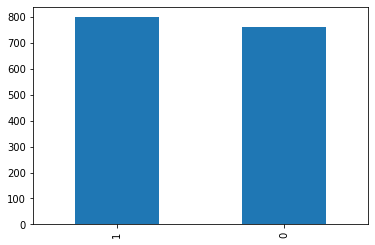

In [150]:
df['positivity'].value_counts().plot(kind="bar")

In [151]:
# df = df.drop('polarity', axis = 1)
# df.head(2)

___

In [152]:
X = df['transcript']
y = df['positivity']

### Baseline - Classifier

In [153]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [154]:
len(x_test)

312

In [155]:
baseline_predictions = [randint(0,1) for b in range(1, len(x_test) + 1)]

In [156]:
print(classification_report(y_test, baseline_predictions))

              precision    recall  f1-score   support

           0       0.53      0.55      0.54       158
           1       0.52      0.51      0.51       154

    accuracy                           0.53       312
   macro avg       0.53      0.53      0.53       312
weighted avg       0.53      0.53      0.53       312



In [157]:
baseline_accuracy = accuracy_score(y_test, baseline_predictions)

### Classifier

In [162]:
v = TfidfVectorizer(stop_words=stopwords.words('english'))

In [163]:
X_tfidf = v.fit_transform(X).toarray()

In [204]:
# pickle.dump(v.vocabulary_,open("data/tfidf_classifier.pkl","wb"))

In [166]:
x_train, x_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2)

In [167]:
model_svm = LinearSVC().fit(x_train, y_train)

In [168]:
predictions = model_svm.predict(x_test)

In [169]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.95      0.93      0.94       166
           1       0.92      0.95      0.93       146

    accuracy                           0.94       312
   macro avg       0.94      0.94      0.94       312
weighted avg       0.94      0.94      0.94       312



In [170]:
clasifier_accuracy = accuracy_score(y_test, predictions)

___

In [171]:
print('Improvement %:', str(((clasifier_accuracy - baseline_accuracy) * 100) / baseline_accuracy))

Improvement %: 76.96969696969697


___

___

In [1]:
import pandas as pd
from textblob import TextBlob
from nltk.corpus import stopwords

In [95]:
df_final = pd.read_json('app/irsystem/data/final_data_url.json')

In [185]:
df_final['source'].unique()

array(['goodnewsnetwork.org', 'The New Daily', 'Newser', 'The Guardian',
       'reddit.com/r/UpliftingNews'], dtype=object)

In [189]:
len(df_final[df_final['source'] != 'reddit.com/r/UpliftingNews'])

953

In [190]:
df_reddit = df_final[df_final['source'] == 'reddit.com/r/UpliftingNews']

In [191]:
def calculate_polarity(row):
    return TextBlob(row).sentiment.polarity
    
df_reddit['polarity'] = df_reddit['transcript'].apply(calculate_polarity)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [196]:
df_reddit['polarity'].describe()['25%']

0.0

In [197]:
df_reddit[df_reddit['polarity'] > df_reddit['polarity'].describe()['25%']]

,title,url,date,transcript,source,subtitle,score,comments,thumbnail,polarity
953,"Lonely redditor shares phone number, reddit se...",http://www.reddit.com/r/offmychest/comments/15...,2013-01-01,"It's New Years Eve, i'm a 22 year old male try...",reddit.com/r/UpliftingNews,NaN,1.0,0.0,default,0.183442
954,A friend of mine witnessed an act of incredibl...,http://imgur.com/CgkRP,2013-01-01,A friend of mine witnessed an act of incredibl...,reddit.com/r/UpliftingNews,NaN,1365.0,37.0,http://d.thumbs.redditmedia.com/AiOVoLUsH0NLia...,0.900000
955,Whenever she feels that her grief for her daug...,http://www.dailymail.co.uk/health/article-2255...,2013-01-01,"When Lindsey's daughter died, her organs saved...",reddit.com/r/UpliftingNews,NaN,65.0,5.0,http://a.thumbs.redditmedia.com/rCSRYYHULtAWfl...,0.096090
956,Fisherman Saved by Boy,http://www.stuff.co.nz/national/8130529/The-bo...,2013-01-01,"Two 12 year-old boys, Will White and Sergio Sc...",reddit.com/r/UpliftingNews,NaN,26.0,1.0,default,0.123188
957,"Sergeant First Class Eric Pazz Surprises Wife,...",http://www.huffingtonpost.com/2013/01/01/eric-...,2013-01-01,"PASADENA, Calif. -- The best moment of the 201...",reddit.com/r/UpliftingNews,NaN,26.0,0.0,default,0.060542
...,...,...,...,...,...,...,...,...,...,...
4361,NIPER Recruitment 2018 – Teaching &amp; Non Te...,http://www.sarkariformadda.com/niper-recruitme...,2019-12-01,National Institute of Pharmaceutical Education...,reddit.com/r/UpliftingNews,NaN,1.0,0.0,default,0.081250
4363,Pretty cool right guys?,https://v.redd.it/1b1oylmm75241,2019-12-01,"Sorry, this post has been removed by the moder...",reddit.com/r/UpliftingNews,NaN,1.0,0.0,default,0.116667
4364,Cuba found to be the most sustainably develope...,https://morningstaronline.co.uk/article/w/cuba...,2019-12-01,CUBA is the most sustainably developed country...,reddit.com/r/UpliftingNews,NaN,1.0,5.0,https://b.thumbs.redditmedia.com/hDwEWmU399dVs...,0.182283
4365,"Compassionate Restaurant Sets Up ""Take One Lea...",https://understandingcompassion.com/compassion...,2019-12-01,"Winter is not an easy time for the homeless, a...",reddit.com/r/UpliftingNews,NaN,1.0,0.0,default,0.261244


___

In [198]:
df_final['polarity'] = df_final['transcript'].apply(calculate_polarity)

In [199]:
df_final.to_json('app/irsystem/data/final_data_url_polarity.json', orient='records')

In [201]:
df_final_filtered = df_final[df_final['polarity'] > 0]

In [203]:
df_final_filtered.to_json('app/irsystem/data/final_data_url_polarity_filtered.json', orient='records')

___